In [1]:
import os
os.environ["NUMBA_THREADING_LAYER"] = "omp"

import numba
import sys
if 'google.colab' in sys.modules:
    !pip --quiet install open-atmos-jupyter-utils
    from open_atmos_jupyter_utils import pip_install_on_colab
    pip_install_on_colab('PyMPDATA-examples')
!pip install PyMPDATA
!pip install --quiet pint

In [2]:
import numpy as np
from matplotlib import pyplot
from open_atmos_jupyter_utils import show_plot, show_anim
from PyMPDATA import ScalarField, Solver, Stepper, VectorField, Options, boundary_conditions
import pint 
u = pint.UnitRegistry()

In [3]:
class ShallowWaterEquationsIntegrator:
    def __init__(self, *, h_initial: np.ndarray, bathymetry: np.ndarray, uh_initial: np.ndarray = None,
                 vh_initial: np.ndarray = None, options: Options = None):
        """ initializes the solvers for a given initial condition of `h` assuming zero momenta at t=0 """
        options = options or Options(nonoscillatory=True, infinite_gauge=True)
        X, Y, grid = 0, 1, h_initial.shape
        if uh_initial is None:
            uh_initial = np.zeros(grid)
        if vh_initial is None:
            vh_initial = np.zeros(grid)
        stepper = Stepper(options=options, grid=grid)
        kwargs = {
            'boundary_conditions': [boundary_conditions.Constant(value=0)] * len(grid),
            'halo': options.n_halo,
        }
        # kwargs = {
        #     'boundary_conditions': [boundary_conditions.Extrapolated()] * len(grid),
        #     'halo': options.n_halo,
        # }
        advectees = {
            "h": ScalarField(h_initial, **kwargs),
            "uh": ScalarField(uh_initial, **kwargs),
            "vh": ScalarField(vh_initial, **kwargs),
        }
        self.advector = VectorField((
                np.zeros((grid[X] + 1, grid[Y])),
                np.zeros((grid[X], grid[Y] + 1))
            ), **kwargs
        )
        self.solvers = { k: Solver(stepper, v, self.advector) for k, v in advectees.items() }
        self.bathymetry = bathymetry

    def __getitem__(self, key):
        """ returns `key` advectee field of the current solver state """
        return self.solvers[key].advectee.get()
    
    def _apply_half_rhs(self, *, key, axis, g_times_dt_over_dxy):
        """ applies half of the source term in the given direction """
        self[key][:] -= .5 * g_times_dt_over_dxy * self['h'] * np.gradient(self['h']-self.bathymetry, axis=axis)

    def _update_courant_numbers(self, *, axis, key, mask, dt_over_dxy):
        """ computes the Courant number component from fluid column height and momenta fields """
        velocity = np.where(mask, np.nan, 0)
        momentum = self[key]
        np.divide(momentum, self['h'], where=mask, out=velocity)

        # using slices to ensure views (over copies)
        all = slice(None, None) 
        all_but_last = slice(None, -1)
        all_but_first_and_last = slice(1, -1)

        velocity_at_cell_boundaries = velocity[( 
            (all_but_last, all),
            (all, all_but_last),
        )[axis]] + np.diff(velocity, axis=axis) / 2 
        courant_number = self.advector.get_component(axis)[(
            (all_but_first_and_last, all),
            (all, all_but_first_and_last)
        )[axis]]
        courant_number[:] = velocity_at_cell_boundaries * dt_over_dxy[axis]
        # print(f"Max Courant number along axis {axis}: {np.amax(np.abs(courant_number)):.10f}")
        assert np.amax(np.abs(courant_number)) <= 1

    def __call__(self, *, nt: int, g: float, dt_over_dxy: tuple, outfreq: int, eps: float=1e-8):
        """ integrates `nt` timesteps and returns a dictionary of solver states recorded every `outfreq` step[s] """
        output = {k: [] for k in self.solvers.keys()}
        for it in range(nt + 1): 
            if it != 0:
                mask = self['h'] > eps
                for axis, key in enumerate(("uh", "vh")):
                    self._update_courant_numbers(axis=axis, key=key, mask=mask, dt_over_dxy=dt_over_dxy)
                self.solvers["h"].advance(n_steps=1)
                for axis, key in enumerate(("uh", "vh")):
                    self._apply_half_rhs(key=key, axis=axis, g_times_dt_over_dxy=g * dt_over_dxy[axis])
                    self.solvers[key].advance(n_steps=1)
                    self._apply_half_rhs(key=key, axis=axis, g_times_dt_over_dxy=g * dt_over_dxy[axis])
            if it % outfreq == 0:
                for key in self.solvers.keys():
                    output[key].append(self[key].copy())
        return output

In [35]:
def generate_bathymetry(
    grid,
    x_width=1000.0,
    y_width=1000.0,
    depth_deep=6.0,
    depth_shelf=0.3,
    y_shelf_start=50,
    y_shelf_end=150,
    y_slope_end=300,
):

    nx, ny = grid
    y = np.linspace(0.0, x_width, ny)
    x = np.linspace(0.0, y_width, nx)
    X, Y = np.meshgrid(x, y, indexing="ij")

    def smoothstep(y, y0, y1):
        t = np.clip((y - y0) / (y1 - y0), 0, 1)
        return t * t * (3 - 2 * t)

    depth_1d = np.zeros_like(y)

    mask_beach = (y <= y_shelf_start)
    slope = smoothstep(y[mask_beach], 0, y_shelf_start)
    depth_1d[mask_beach] = depth_shelf * slope

    mask_shelf = (y > y_shelf_start) & (y <= y_shelf_end)
    depth_1d[mask_shelf] = depth_shelf

    mask_slope = (y > y_shelf_end) & (y <= y_slope_end)
    slope = smoothstep(y[mask_slope], y_shelf_end, y_slope_end)
    depth_1d[mask_slope] = depth_shelf + (depth_deep - depth_shelf) * slope

    mask_deep = (y > y_slope_end)
    depth_1d[mask_deep] = depth_deep

    bathymetry = np.tile(depth_1d, (nx, 1))

    pyplot.figure(figsize=(10, 6))
    pyplot.plot(y, depth_1d, label="Bathymetry profile")
    pyplot.fill_between(y, 0, depth_1d, color='lightblue')
    pyplot.gca().invert_yaxis()
    pyplot.xlabel("y (km)")
    pyplot.ylabel("Depth (km)")
    pyplot.title("Bathymetry Profile")
    pyplot.grid()
    show_plot(filename="bathymetry_profile.png")

    return bathymetry, X, Y, depth_1d

def make_h_initial(
    bathymetry, X, Y,
    uplift_amp_m = 7.0,
    subsidence_amp_m = 2.5,
    x_frac = 0.5,
    x_witdt_km = 200.0,
    y_frac = 0.5,
    y_width_km = 50.0,
):

    Lx = X.max() - X.min()
    Ly = Y.max() - Y.min()

    uplift_km     = uplift_amp_m     / 1000.0
    subsidence_km = subsidence_amp_m / 1000.0
    x0 = x_frac * Lx
    y0 = y_frac * Ly
    sigma_x = x_witdt_km / 2.0
    sigma_y = y_width_km / 2.0
    y1 = y0 - sigma_y 
    y2 = y0 + sigma_y

    gauss_y_uplift = np.exp(-((Y - y1) ** 2) / (2.0 * sigma_y ** 2))
    gauss_y_subs   = np.exp(-((Y - y2) ** 2) / (2.0 * sigma_y ** 2))
    gauss_x = np.exp(-((X - x0) ** 2) / (2.0 * sigma_x ** 2))

    shapeY = uplift_km * gauss_y_uplift - subsidence_km * gauss_y_subs
    shapeX = gauss_x
    eta0 = shapeX * shapeY

    h_initial = bathymetry + eta0

    uh_initial = np.zeros_like(h_initial)
    vh_initial = np.zeros_like(h_initial)

    fig, ax = pyplot.subplots(figsize=(8, 6))

    im = ax.imshow(
        eta0 * 1000.0,
        origin="lower",
        extent=[Y.min(), Y.max(), X.min(), X.max()],
        aspect="auto"
    )

    cbar = pyplot.colorbar(im, ax=ax, pad=0.02)
    cbar.set_label("η (m)", fontsize=12)
    ax.set_xlabel("y (km)", fontsize=12)
    ax.set_ylabel("x (km)", fontsize=12)
    ax.set_title("Initial disturbance of the water surface", fontsize=12)
    ax.grid(False)
    pyplot.tight_layout()
    show_plot(filename="initial_eta.png")

    # nx, ny = bathymetry.shape
    # ix_mid = nx // 2
    # y_coords = Y[ix_mid, :]
    # eta_section_m = eta0[ix_mid, :] * 1000.0 

    # fig, ax = pyplot.subplots(figsize=(8, 6))
    # ax.plot(y_coords, eta_section_m, label="η(y)")
    # ax.axhline(0.0, color="k", linewidth=0.8)
    # ax.set_xlabel("y (km)", fontsize=12)
    # ax.set_ylabel("η (m)", fontsize=12)
    # ax.set_title("initial disturbance of the water surface", fontsize=12)
    # ax.grid(True)
    # ax.legend()

    # pyplot.tight_layout()
    # show_plot(filename="initial_eta_1D.png")

    return h_initial, vh_initial, uh_initial


dx = 1.00 kilometer, dy = 1.00 kilometer, dt = 0.03000 minute, dt_over_dxy = 0.03000 minute / kilometer, 0.03000 minute / kilometer


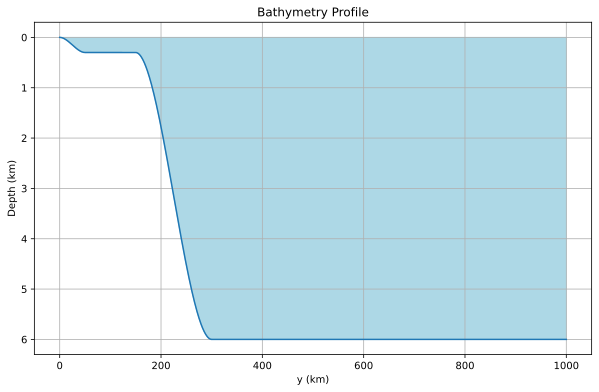

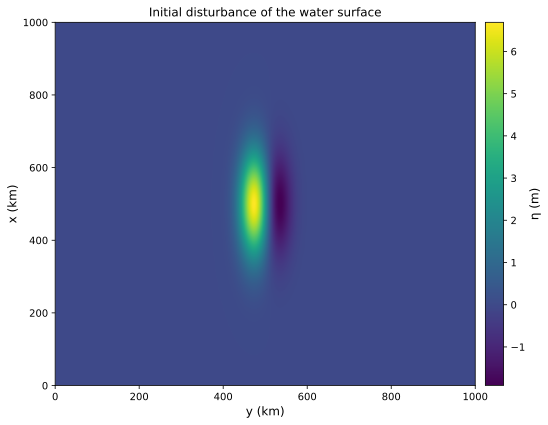

In [36]:
# simulation parameters

grid = (1001, 1001)
g = 10.0 * u.m / u.s**2
g_km_per_min2 = g.to(u.km / u.min**2).magnitude
outfreq = 40

# physical parameters

L_km = 1000.0 * u.km
shelf_end=150
slope_end=300
v_tsunami = 800.0 / 60.0 *u.km / u.min

###########################################################################

nx, ny = grid
dx_km = L_km / (nx - 1)
dy_km = L_km / (ny - 1)

C = 0.4
dt = dy_km / v_tsunami * C

dt_over_dxy = (dt / dx_km, dt / dy_km)

print(f"dx = {dx_km:.2f}, dy = {dy_km:.2f}, dt = {dt:.5f}, dt_over_dxy = {dt_over_dxy[0]:.5f}, {dt_over_dxy[1]:.5f}")

bathymetry, X, Y, depth_y = generate_bathymetry(grid=grid, x_width=L_km.magnitude, y_width=L_km.magnitude, y_shelf_end=shelf_end, y_slope_end=slope_end)
h_initial, vh_initial, uh_initial = make_h_initial(bathymetry, X, Y, )

In [23]:
g = 10.0 * u.m / u.s**2
g_km_per_min2 = g.to(u.km / u.min**2).magnitude
outfreq = 40

output = ShallowWaterEquationsIntegrator(
    h_initial=h_initial, bathymetry=bathymetry, uh_initial=uh_initial, vh_initial=vh_initial
)(
    nt=2500,
    g=g_km_per_min2,
    dt_over_dxy=(dt_over_dxy[0].magnitude, dt_over_dxy[1].magnitude),
    outfreq=outfreq
)

print("Integration complete.")

Integration complete.


In [ ]:
with open('tsunami_output.txt', 'wb') as f:
    np.savez_compressed(f, 
        h=np.array(output['h']),
        uh=np.array(output['uh']),
        vh=np.array(output['vh']),
        bathymetry=bathymetry
    )

print("Output saved to tsunami_output.txt")

# with open('tsunami_output.txt', 'rb') as f:   
#     data = np.load(f)
#     h_data = data['h']
#     uh_data = data['uh']
#     vh_data = data['vh']
#     bathymetry_data = data['bathymetry']

# output = {
#     'h': h_data,
#     'uh': uh_data,
#     'vh': vh_data
# }

# dt_dxy = 0.08
# outfreq = 40

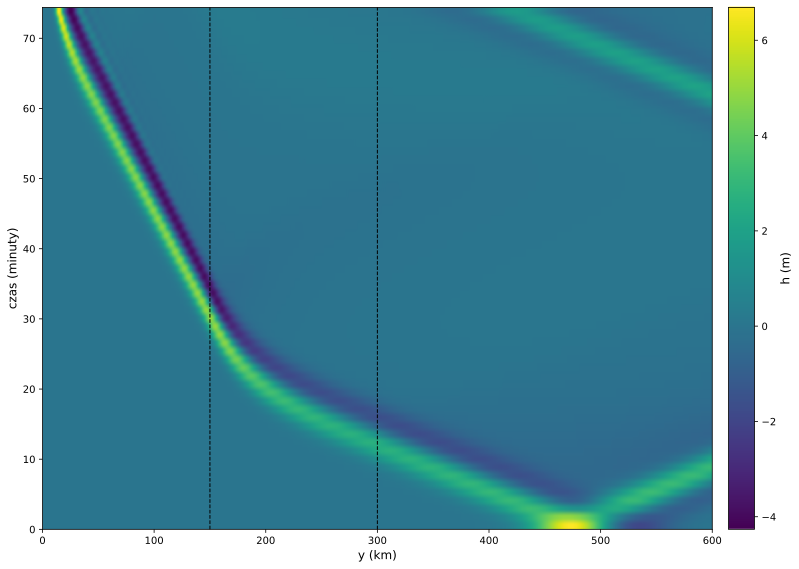

In [ ]:
def plot_space_time_diagram(output, bathymetry, y_coords, dt, outfreq, 
                shelf_end, slope_end, type = "h", cmap="viridis", x_index=None):

    h_snaps = np.array(output["h"])
    v_snaps = np.array(output["vh"])

    nx, ny = bathymetry.shape

    if x_index is None:
        x_index = nx // 2

    if type == "h":
        wave = (h_snaps[:, x_index, :] - bathymetry[x_index, :]) * 1e3
    elif type == "vh":
        wave = v_snaps[:, x_index, :] / h_snaps[:, x_index, :] * 60.0
    else:
        raise ValueError("type must be 'h' or 'vh'")
    
    n_snaps = wave.shape[0]
    time = np.arange(n_snaps) * outfreq * dt


    fig, ax = pyplot.subplots(figsize=(10, 6))
    im = ax.imshow(
        wave,
        aspect="auto",
        origin="lower",
        extent=[y_coords[0], y_coords[-1], time[0], time[-1]],
        cmap=cmap
    )

    ax.set_xlabel("y (km)", fontsize=12)
    ax.set_ylabel("czas (minuty)", fontsize=12)
    ax.set_xlim(0, 600)
    ax.grid(False)

    ax.axvline(x=shelf_end, color='black', linestyle='--', linewidth=1)
    ax.axvline(x=slope_end, color='black', linestyle='--', linewidth=1)

    cbar = pyplot.colorbar(im, ax=ax, pad=0.02)
    if type == "h":
        cbar.set_label("h (m)", fontsize=12)
    if type == "vh":
        cbar.set_label("v (km/h)", fontsize=12)

    pyplot.tight_layout()
    show_plot(filename=f"hovmoller_{type}.png")
   
plot_space_time_diagram(output=output,
    bathymetry=bathymetry, 
    y_coords=np.linspace(0, L_km.magnitude, bathymetry.shape[1]), 
    dt=dt.magnitude, 
    outfreq=outfreq, 
    slope_end=slope_end, 
    shelf_end=shelf_end,
    type='h')


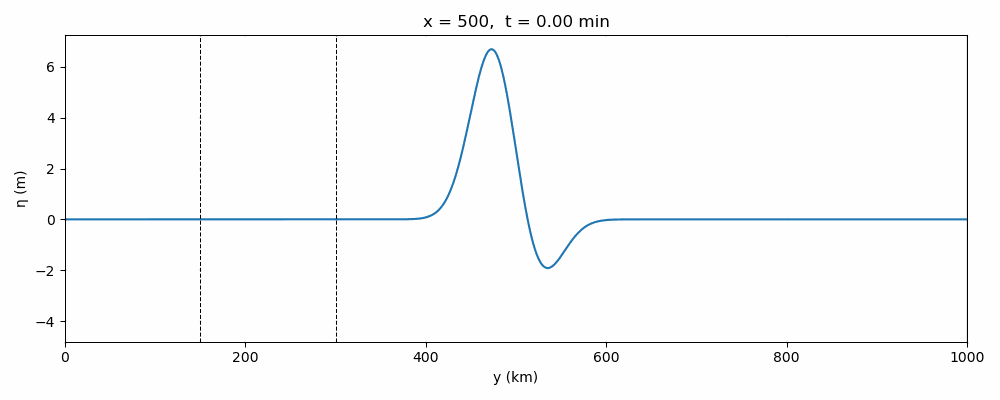

HTML(value="<a href='./tmp5drpxucq.gif' target='_blank'>./tmp5drpxucq.gif</a><br>")

In [ ]:
def animate_cross_section_y(
    output,
    bathymetry,
    y_coords,
    dt,
    outfreq,
    shelf_end,
    slope_end,
    type="h",
    cmap="viridis",
    x_index=None,
):
    
    h_snaps = np.asarray(output["h"])
    v_snaps = np.asarray(output["vh"])
    nx, ny = bathymetry.shape
    if x_index is None:
        x_index = nx // 2

    if type == "h":
        wave_all = (h_snaps[:, x_index, :] - bathymetry[x_index, :]) * 1e3  # [m]
        ylabel = "η (m)"
    elif type == "vh":
        wave_all = v_snaps[:, x_index, :] / h_snaps[:, x_index, :] * 60.0   # [km/h]
        ylabel = "v (km/h)"
    else:
        raise ValueError("type musi być 'h' albo 'vh'")

    n_snaps, ny = wave_all.shape

    w_min = np.min(wave_all)
    w_max = np.max(wave_all)
    padding = 0.05 * (w_max - w_min if w_max != w_min else 1.0)
    ylim = (w_min - padding, w_max + padding)

    def plot(frame, *, ylim=ylim):
        psi = wave_all[frame, :]
        t_min = frame * outfreq * dt
        fig, ax = pyplot.subplots(figsize=(10, 4))

        ax.plot(y_coords, psi, linewidth=1.5)

        ax.axvline(x=shelf_end, color="black", linestyle="--", linewidth=0.8)
        ax.axvline(x=slope_end, color="black", linestyle="--", linewidth=0.8)

        ax.set(
            xlim=(y_coords[0], y_coords[-1]),
            ylim=ylim,
            xlabel="y (km)",
            ylabel=ylabel,
            title=f"x = {x_index},  t = {t_min:.2f} min",
        )

        ax.grid(True, linewidth=0.3, alpha=0.4)
        pyplot.tight_layout()
        return fig
    show_anim(plot, range(n_snaps))

y_coords = np.linspace(0, L_km.magnitude, bathymetry.shape[1])

animate_cross_section_y(
    output=output,
    bathymetry=bathymetry,
    y_coords=y_coords,
    dt=dt.magnitude,
    outfreq=outfreq,
    shelf_end=shelf_end,
    slope_end=slope_end,
    type="h",
    x_index=None,
)



TypeError: Invalid shape (63, 1001, 1001) for image data

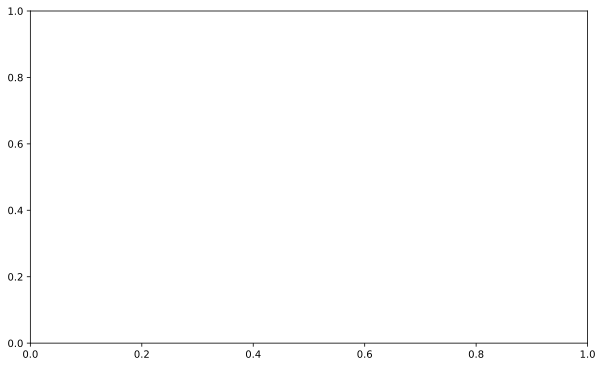

In [ ]:
def plot_space_time_diagram(
    output, bathymetry, y_coords, dt, outfreq, 
    shelf_end, slope_end, cmap="viridis", x_index=None,
    pos_segments=None, 
):

    wave = np.array(output["h"])

    nx, ny = bathymetry.shape

    if x_index is None:
        x_index = nx // 2

    cbar_label = "h (m)"
    
    n_snaps = wave.shape[0]
    time = np.arange(n_snaps) * outfreq * dt

    fig, ax = pyplot.subplots(figsize=(10, 6))
    im = ax.imshow(
        wave,
        aspect="auto",
        origin="lower",
        extent=[y_coords[0], y_coords[-1], time[0], time[-1]],
        cmap=cmap
    )

    ax.set_xlabel("y (km)", fontsize=12)
    ax.set_ylabel("czas (minuty)", fontsize=12)
    ax.set_xlim(0, 600)
    ax.grid(False)

    ax.axvline(x=shelf_end, color='black', linestyle='--', linewidth=1)
    ax.axvline(x=slope_end, color='black', linestyle='--', linewidth=1)

    cbar = pyplot.colorbar(im, ax=ax, pad=0.02)
    cbar.set_label("h (m)", fontsize=12)


    if pos_segments is not None:
        for idx, (y_min_seg, y_max_seg) in enumerate(pos_segments):

            # wybieramy indeksy y w danym przedziale
            mask = (y_coords >= y_min_seg) & (y_coords <= y_max_seg)
            seg_indices = np.where(mask)[0]

            if len(seg_indices) < 2:
                print(f"Segment {idx+1}: za mało punktów w y, pomijam.")
                continue

            sub_wave = wave[:, seg_indices]
            sub_y    = y_coords[seg_indices] 

            crest_local_idx = np.argmax(sub_wave, axis=1)
            crest_y = sub_y[crest_local_idx]

            a, b = np.polyfit(time, crest_y, 1)
            v_km_per_min = a
            v_kmh = v_km_per_min * 60.0

            ax.plot(crest_y, time, '.', markersize=2, label=None)
            ax.plot(a * time + b, time, '--', linewidth=1)

            ax.text(
                0.02, 0.97 - idx * 0.05,
                f"segment {idx+1} (y∈[{y_min_seg:.0f},{y_max_seg:.0f}] km): v ≈ {v_kmh:.1f} km/h",
                transform=ax.transAxes,
                fontsize=9,
                va='top',
                color='white',
                bbox=dict(facecolor='black', alpha=0.4, boxstyle='round,pad=0.2')
            )

    pyplot.tight_layout()
    show_plot(filename=f"hovmoller_{type}.png")

plot_space_time_diagram(
    output=output,
    bathymetry=bathymetry, 
    y_coords=np.linspace(0, L_km.magnitude, bathymetry.shape[1]), 
    dt=dt.magnitude, 
    outfreq=outfreq, 
    slope_end=slope_end, 
    shelf_end=shelf_end,
    type='h',
    pos_segments=[(100, 200), (250, 350), (400, 500)]
)